In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import TextVectorization
import re,string
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,LayerNormalization

In [2]:
# Load the dataset
df = pd.read_excel("Allergy.xlsx",header=0)

In [3]:
# Set display options to show full content without truncation
pd.set_option('display.max_colwidth', None)
NewData = df[['Patient','Doctor']]

In [4]:
print(f'Dataframe size: {len(NewData)}')
NewData.head(20)

Dataframe size: 189


,Patient,Doctor
0,"Doctor, I've been feeling really strange lately. I had a reaction after eating something, and my throat felt like it was closing up. I'm really worried. Can you help me?","Of course, I'll do my best to help you. It sounds like you may have experienced an allergic reaction. Can you tell me more about what happened?"
1,"Well, I was at a restaurant and I had this dish with shrimp. Shortly after I finished eating, my lips started to swell, and I had difficulty breathing. I've never had this happen before, and it scared me.","I understand your concern. Based on your symptoms, it's possible that you had a severe allergic reaction called anaphylaxis. This is a serious condition that requires immediate medical attention. Have you experienced any other symptoms, such as hives, itching, or lightheadedness?"
2,"Yes, actually, I did notice some hives on my arms and chest, and I felt lightheaded and dizzy. I had no idea this could happen from eating shrimp. What exactly is anaphylaxis?","That's probably what's causing your reaction. Pork is a common allergen, and it can cause a variety of symptoms, including hives, difficulty breathing, and even anaphylaxis."
3,"Anaphylaxis is a severe allergic reaction that can occur within minutes or even seconds after exposure to an allergen, such as shrimp in your case. It can affect multiple systems in your body and can be life-threatening if not treated promptly. Common symptoms include swelling of the lips, face, or throat, difficulty breathing, hives or rash, and a drop in blood pressure leading to dizziness or fainting.",That sounds really serious! I had no idea an allergic reaction could be so dangerous. What should I do if it happens again?
4,"Good morning, Doctor. I've been experiencing some unusual symptoms, and I'm not sure what's going on. I noticed some skin issues and recently had a blood test done. Can you please take a look at the reports and help me understand what's happening?","Good morning. Of course, I'll be happy to assist you. Please hand me your reports, and let's discuss your symptoms in detail. What specific skin issues have you been experiencing?"
5,"Well, I've been having frequent rashes and hives on different parts of my body. They appear as red, itchy patches, and they come and go randomly. It's quite uncomfortable, and I'm not sure what triggers them.","I see. Skin rashes and hives can be indicative of an allergic reaction. It's important to identify the underlying cause. Now, let's take a look at your blood test results. Could you please pass them to me?"
6,"Here are the reports, Doctor. I hope they can provide some insight into my condition.",Thank you. Let me review these reports.
7,"Doctor, I had a really scary experience after eating pork yesterday. My face swelled up, and I had difficulty breathing. I think it might have been an allergic reaction. Can you help me understand what happened?",I'm sorry to hear about your distressing experience. Allergic reactions can indeed occur after consuming certain foods. Let's discuss your symptoms in more detail. Did you notice any other reactions apart from the facial swelling and difficulty breathing?
8,"Yes, I also had hives on my body, and I felt quite dizzy. It was really frightening, and I had no idea that this could happen from eating pork. Is it possible that I have an allergy to pork?","It's possible that you have developed an allergy to pork. Allergic reactions can vary from person to person, and some individuals can be allergic to specific types of meat. To better understand your condition, it would be helpful to review your skin and blood test reports. Can you please provide me with those?"
9,"Certainly, Doctor. Here are the reports. I hope they can shed some light on what's happening.","Thank you. Let me take a look at the report .Based on your blood test results, your IgE levels are elevated, indicating a possible allergic reaction. Additionally, your skin prick test shows a positive reaction to p

In [5]:
NewData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Patient  176 non-null    object
 1   Doctor   179 non-null    object
dtypes: object(2)
memory usage: 3.1+ KB


C:\Users\Nuwanga Wijamuni\AppData\Local\Temp\ipykernel_12504\1690811942.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  NewData['question Tokens'] = NewData['Patient'].apply(lambda x: len(str(x).split()))


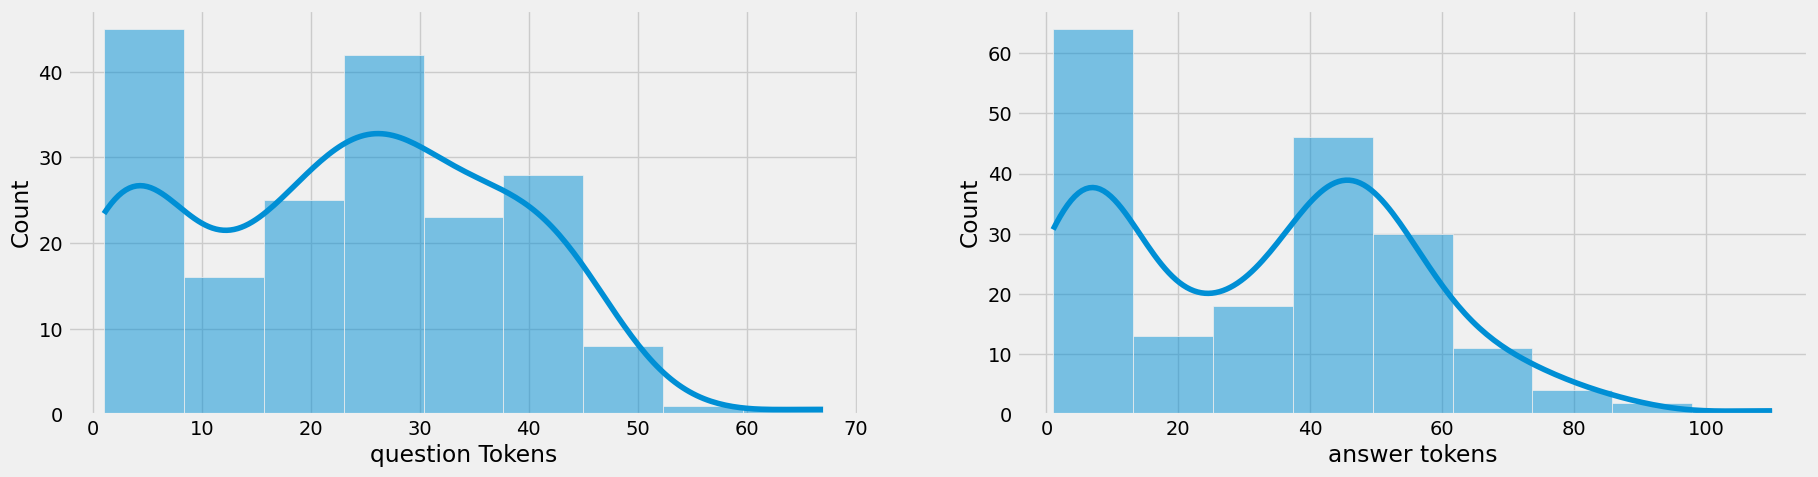

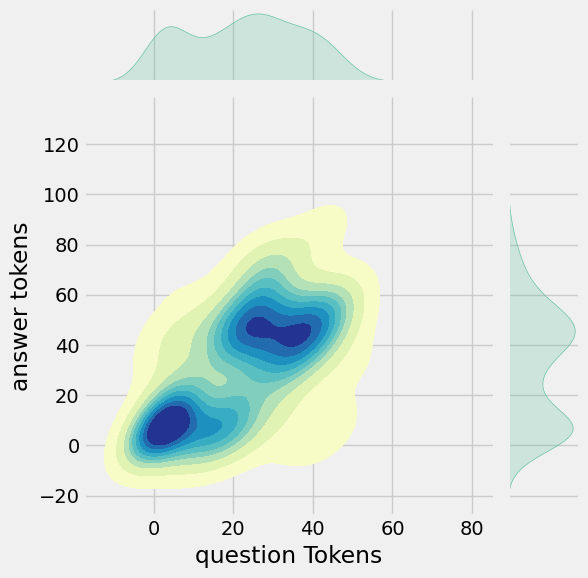

In [6]:
NewData['question Tokens'] = NewData['Patient'].apply(lambda x: len(str(x).split()))
NewData['answer tokens'] = NewData['Doctor'].apply(lambda x: len(str(x).split()))
plt.style.use('fivethirtyeight')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
sns.set_palette('Set2')

sns.histplot(x=NewData['question Tokens'], data=NewData, kde=True, ax=ax[0])
sns.histplot(x=NewData['answer tokens'], data=NewData, kde=True, ax=ax[1])
sns.jointplot(x='question Tokens', y='answer tokens', data=NewData, kind='kde', fill=True, cmap='YlGnBu')

plt.show()
plt.show()

In [7]:

def clean_text(text):
    text=re.sub('-',' ',text.lower())
    text=re.sub('[.]',' . ',text)
    text=re.sub('[1]',' 1 ',text)
    text=re.sub('[2]',' 2 ',text)
    text=re.sub('[3]',' 3 ',text)
    text=re.sub('[4]',' 4 ',text)
    text=re.sub('[5]',' 5 ',text)
    text=re.sub('[6]',' 6 ',text)
    text=re.sub('[7]',' 7 ',text)
    text=re.sub('[8]',' 8 ',text)
    text=re.sub('[9]',' 9 ',text)
    text=re.sub('[0]',' 0 ',text)
    text=re.sub('[,]',' , ',text)
    text=re.sub('[?]',' ? ',text)
    text=re.sub('[!]',' ! ',text)
    text=re.sub('[$]',' $ ',text)
    text=re.sub('[&]',' & ',text)
    text=re.sub('[/]',' / ',text)
    text=re.sub('[:]',' : ',text)
    text=re.sub('[;]',' ; ',text)
    text=re.sub('[*]',' * ',text)
    text=re.sub('[\']',' \' ',text)
    text=re.sub('[\"]',' \" ',text)
    text=re.sub('\t',' ',text)
    return text

In [8]:
NewData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Patient          176 non-null    object
 1   Doctor           179 non-null    object
 2   question Tokens  189 non-null    int64 
 3   answer tokens    189 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 6.0+ KB


In [9]:
NewData.drop(columns=['answer tokens', 'question Tokens'], inplace=True)
NewData['encoder_inputs'] = NewData['Patient'].astype(str).apply(clean_text)
NewData['decoder_targets'] = NewData['Doctor'].apply(lambda x: clean_text(x) if pd.notnull(x) else '')
NewData['decoder_targets'] += ' <end>'
NewData['decoder_inputs'] = '<start> ' + NewData['Doctor'].apply(lambda x: clean_text(x) if pd.notnull(x) else '')
NewData['decoder_inputs'] += ' <end>'
NewData.head(10)

,Patient,Doctor,encoder_inputs,decoder_targets,decoder_inputs
0,"Doctor, I've been feeling really strange lately. I had a reaction after eating something, and my throat felt like it was closing up. I'm really worried. Can you help me?","Of course, I'll do my best to help you. It sounds like you may have experienced an allergic reaction. Can you tell me more about what happened?","doctor , i ' ve been feeling really strange lately . i had a reaction after eating something , and my throat felt like it was closing up . i ' m really worried . can you help me ?","of course , i ' ll do my best to help you . it sounds like you may have experienced an allergic reaction . can you tell me more about what happened ? <end>","<start> of course , i ' ll do my best to help you . it sounds like you may have experienced an allergic reaction . can you tell me more about what happened ? <end>"
1,"Well, I was at a restaurant and I had this dish with shrimp. Shortly after I finished eating, my lips started to swell, and I had difficulty breathing. I've never had this happen before, and it scared me.","I understand your concern. Based on your symptoms, it's possible that you had a severe allergic reaction called anaphylaxis. This is a serious condition that requires immediate medical attention. Have you experienced any other symptoms, such as hives, itching, or lightheadedness?","well , i was at a restaurant and i had this dish with shrimp . shortly after i finished eating , my lips started to swell , and i had difficulty breathing . i ' ve never had this happen before , and it scared me .","i understand your concern . based on your symptoms , it ' s possible that you had a severe allergic reaction called anaphylaxis . this is a serious condition that requires immediate medical attention . have you experienced any other symptoms , such as hives , itching , or lightheadedness ? <end>","<start> i understand your concern . based on your symptoms , it ' s possible that you had a severe allergic reaction called anaphylaxis . this is a serious condition that requires immediate medical attention . have you experienced any other symptoms , such as hives , itching , or lightheadedness ? <end>"
2,"Yes, actually, I did notice some hives on my arms and chest, and I felt lightheaded and dizzy. I had no idea this could happen from eating shrimp. What exactly is anaphylaxis?","That's probably what's causing your reaction. Pork is a common allergen, and it can cause a variety of symptoms, including hives, difficulty breathing, and even anaphylaxis.","yes , actually , i did notice some hives on my arms and chest , and i felt lightheaded and dizzy . i had no idea this could happen from eating shrimp . what exactly is anaphylaxis ?","that ' s probably what ' s causing your reaction . pork is a common allergen , and it can cause a variety of symptoms , including hives , difficulty breathing , and even anaphylaxis . <end>","<start> that ' s probably what ' s causing your reaction . pork is a common allergen , and it can cause a variety of symptoms , including hives , difficulty breathing , and even anaphylaxis . <end>"
3,"Anaphylaxis is a severe allergic reaction that can occur within minutes or even seconds after exposure to an allergen, such as shrimp in your case. It can affect multiple systems in your body and can be life-threatening if not treated promptly. Common symptoms include swelling of the lips, face, or throat, difficulty breathing, hives or rash, and a drop in blood pressure leading to dizziness or fainting.",That sounds really serious! I had no idea an allergic reaction could be so dangerous. What should I do if it happens again?,"anaphylaxis is a severe allergic reaction that can occur within minutes or even seconds after exposure to an allergen , such as shrimp in your case . it can affect multiple systems in your body and can be life threatening if not treated promptly . common symptoms include swelling of the lips , face , or throat , difficulty brea

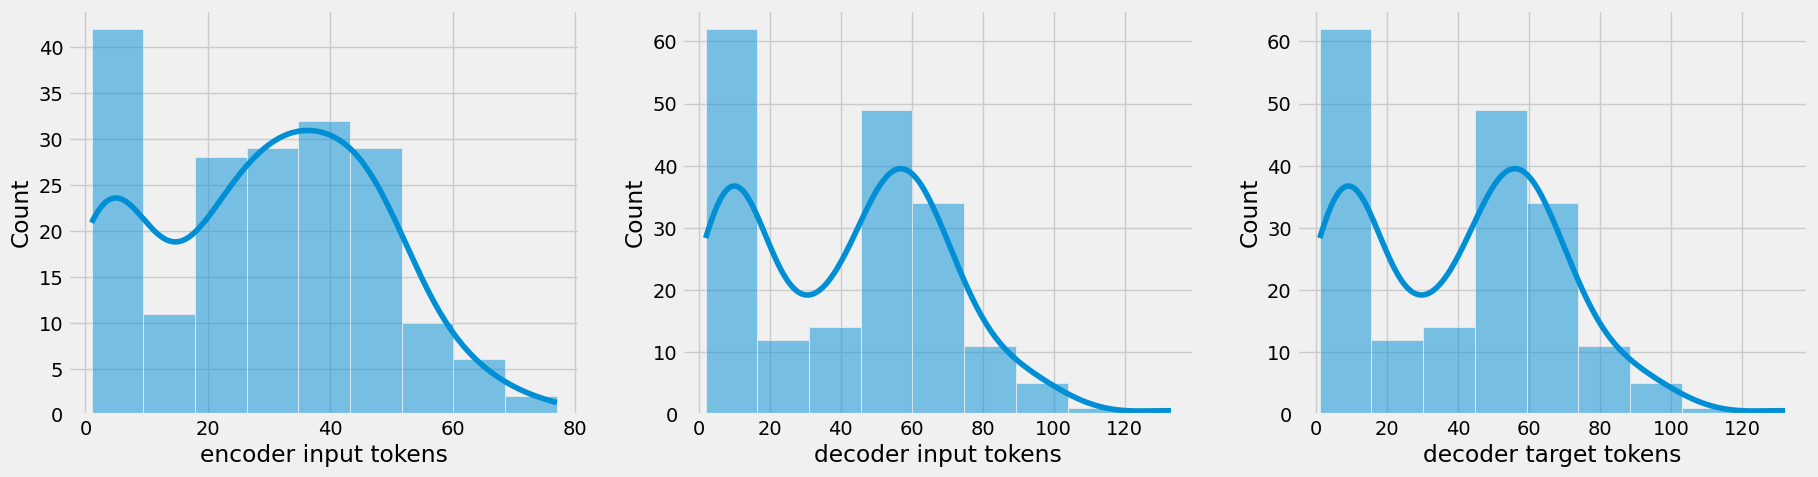

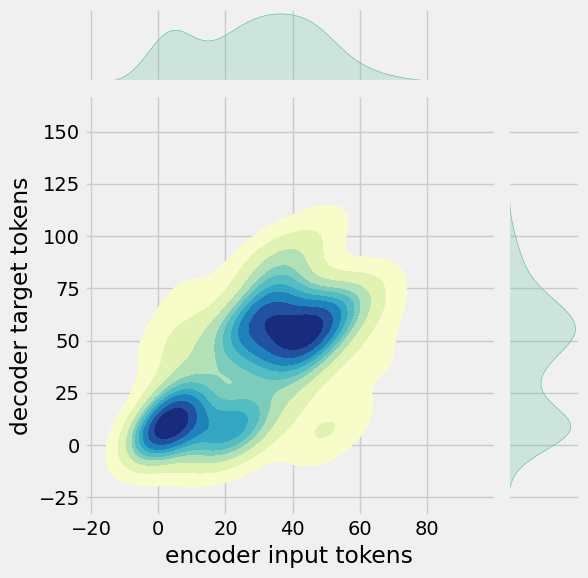

In [10]:
NewData['encoder input tokens']=NewData['encoder_inputs'].apply(lambda x:len(x.split()))
NewData['decoder input tokens']=NewData['decoder_inputs'].apply(lambda x:len(x.split()))
NewData['decoder target tokens']=NewData['decoder_targets'].apply(lambda x:len(x.split()))
plt.style.use('fivethirtyeight')
fig,ax=plt.subplots(nrows=1,ncols=3,figsize=(20,5))
sns.set_palette('Set2')
sns.histplot(x=NewData['encoder input tokens'],data=NewData,kde=True,ax=ax[0])
sns.histplot(x=NewData['decoder input tokens'],data=NewData,kde=True,ax=ax[1])
sns.histplot(x=NewData['decoder target tokens'],data=NewData,kde=True,ax=ax[2])
sns.jointplot(x='encoder input tokens',y='decoder target tokens',data=NewData,kind='kde',fill=True,cmap='YlGnBu')
plt.show()

In [11]:
max_encoder_input_row = NewData['encoder_inputs'].str.split().str.len().argmax()
max_encoder_input = NewData.loc[max_encoder_input_row, 'encoder_inputs']

print(f"After preprocessing: {' '.join(max_encoder_input.split())}")
print(f"Max encoder input length: {NewData['encoder_inputs'].str.split().str.len().max()}")
print(f"Max decoder input length: {NewData['decoder_inputs'].str.split().str.len().max()}")
print(f"Max decoder target length: {NewData['decoder_targets'].str.split().str.len().max()}")

After preprocessing: anaphylaxis is a severe allergic reaction that can occur within minutes or even seconds after exposure to an allergen , such as shrimp in your case . it can affect multiple systems in your body and can be life threatening if not treated promptly . common symptoms include swelling of the lips , face , or throat , difficulty breathing , hives or rash , and a drop in blood pressure leading to dizziness or fainting .
Max encoder input length: 77
Max decoder input length: 133
Max decoder target length: 132


In [12]:
NewData.head()

,Patient,Doctor,encoder_inputs,decoder_targets,decoder_inputs,encoder input tokens,decoder input tokens,decoder target tokens
0,"Doctor, I've been feeling really strange lately. I had a reaction after eating something, and my throat felt like it was closing up. I'm really worried. Can you help me?","Of course, I'll do my best to help you. It sounds like you may have experienced an allergic reaction. Can you tell me more about what happened?","doctor , i ' ve been feeling really strange lately . i had a reaction after eating something , and my throat felt like it was closing up . i ' m really worried . can you help me ?","of course , i ' ll do my best to help you . it sounds like you may have experienced an allergic reaction . can you tell me more about what happened ? <end>","<start> of course , i ' ll do my best to help you . it sounds like you may have experienced an allergic reaction . can you tell me more about what happened ? <end>",40,35,34
1,"Well, I was at a restaurant and I had this dish with shrimp. Shortly after I finished eating, my lips started to swell, and I had difficulty breathing. I've never had this happen before, and it scared me.","I understand your concern. Based on your symptoms, it's possible that you had a severe allergic reaction called anaphylaxis. This is a serious condition that requires immediate medical attention. Have you experienced any other symptoms, such as hives, itching, or lightheadedness?","well , i was at a restaurant and i had this dish with shrimp . shortly after i finished eating , my lips started to swell , and i had difficulty breathing . i ' ve never had this happen before , and it scared me .","i understand your concern . based on your symptoms , it ' s possible that you had a severe allergic reaction called anaphylaxis . this is a serious condition that requires immediate medical attention . have you experienced any other symptoms , such as hives , itching , or lightheadedness ? <end>","<start> i understand your concern . based on your symptoms , it ' s possible that you had a severe allergic reaction called anaphylaxis . this is a serious condition that requires immediate medical attention . have you experienced any other symptoms , such as hives , itching , or lightheadedness ? <end>",47,53,52
2,"Yes, actually, I did notice some hives on my arms and chest, and I felt lightheaded and dizzy. I had no idea this could happen from eating shrimp. What exactly is anaphylaxis?","That's probably what's causing your reaction. Pork is a common allergen, and it can cause a variety of symptoms, including hives, difficulty breathing, and even anaphylaxis.","yes , actually , i did notice some hives on my arms and chest , and i felt lightheaded and dizzy . i had no idea this could happen from eating shrimp . what exactly is anaphylaxis ?","that ' s probably what ' s causing your reaction . pork is a common allergen , and it can cause a variety of symptoms , including hives , difficulty breathing , and even anaphylaxis . <end>","<start> that ' s probably what ' s causing your reaction . pork is a common allergen , and it can cause a variety of symptoms , including hives , difficulty breathing , and even anaphylaxis . <end>",38,38,37
3,"Anaphylaxis is a severe allergic reaction that can occur within minutes or even seconds after exposure to an allergen, such as shrimp in your case. It can affect multiple systems in your body and can be life-threatening if not treated promptly. Common symptoms include swelling of the lips, face, or throat, difficulty breathing, hives or rash, and a drop in blood pressure leading to dizziness or fainting.",That sounds really serious! I had no idea an allergic reaction could be so dangerous. What should I do if it happens again?,"anaphylaxis is a severe allergic reaction that can occur within minutes or even seconds after exposure to an allergen , such as shrimp in your case . it can affect multiple systems in your body and can be life threatening if not treated p

In [13]:
NewData.drop(columns=['Patient','Doctor','encoder input tokens','decoder input tokens','decoder target tokens'],axis=1,inplace=True)
params={
    "vocab_size":4000,
    "max_sequence_length":120,
    "learning_rate":0.008,
    "batch_size":240,
    "lstm_cells":320,
    "embedding_dim":400,
    "buffer_size":15000
}

In [14]:
learning_rate=params['learning_rate']
batch_size=params['batch_size']
embedding_dim=params['embedding_dim']
lstm_cells=params['lstm_cells']
vocab_size=params['vocab_size']
buffer_size=params['buffer_size']
max_sequence_length=params['max_sequence_length']
NewData.head(10)

,encoder_inputs,decoder_targets,decoder_inputs
0,"doctor , i ' ve been feeling really strange lately . i had a reaction after eating something , and my throat felt like it was closing up . i ' m really worried . can you help me ?","of course , i ' ll do my best to help you . it sounds like you may have experienced an allergic reaction . can you tell me more about what happened ? <end>","<start> of course , i ' ll do my best to help you . it sounds like you may have experienced an allergic reaction . can you tell me more about what happened ? <end>"
1,"well , i was at a restaurant and i had this dish with shrimp . shortly after i finished eating , my lips started to swell , and i had difficulty breathing . i ' ve never had this happen before , and it scared me .","i understand your concern . based on your symptoms , it ' s possible that you had a severe allergic reaction called anaphylaxis . this is a serious condition that requires immediate medical attention . have you experienced any other symptoms , such as hives , itching , or lightheadedness ? <end>","<start> i understand your concern . based on your symptoms , it ' s possible that you had a severe allergic reaction called anaphylaxis . this is a serious condition that requires immediate medical attention . have you experienced any other symptoms , such as hives , itching , or lightheadedness ? <end>"
2,"yes , actually , i did notice some hives on my arms and chest , and i felt lightheaded and dizzy . i had no idea this could happen from eating shrimp . what exactly is anaphylaxis ?","that ' s probably what ' s causing your reaction . pork is a common allergen , and it can cause a variety of symptoms , including hives , difficulty breathing , and even anaphylaxis . <end>","<start> that ' s probably what ' s causing your reaction . pork is a common allergen , and it can cause a variety of symptoms , including hives , difficulty breathing , and even anaphylaxis . <end>"
3,"anaphylaxis is a severe allergic reaction that can occur within minutes or even seconds after exposure to an allergen , such as shrimp in your case . it can affect multiple systems in your body and can be life threatening if not treated promptly . common symptoms include swelling of the lips , face , or throat , difficulty breathing , hives or rash , and a drop in blood pressure leading to dizziness or fainting .",that sounds really serious ! i had no idea an allergic reaction could be so dangerous . what should i do if it happens again ? <end>,<start> that sounds really serious ! i had no idea an allergic reaction could be so dangerous . what should i do if it happens again ? <end>
4,"good morning , doctor . i ' ve been experiencing some unusual symptoms , and i ' m not sure what ' s going on . i noticed some skin issues and recently had a blood test done . can you please take a look at the reports and help me understand what ' s happening ?","good morning . of course , i ' ll be happy to assist you . please hand me your reports , and let ' s discuss your symptoms in detail . what specific skin issues have you been experiencing ? <end>","<start> good morning . of course , i ' ll be happy to assist you . please hand me your reports , and let ' s discuss your symptoms in detail . what specific skin issues have you been experiencing ? <end>"
5,"well , i ' ve been having frequent rashes and hives on different parts of my body . they appear as red , itchy patches , and they come and go randomly . it ' s quite uncomfortable , and i ' m not sure what triggers them .","i see . skin rashes and hives can be indicative of an allergic reaction . it ' s important to identify the underlying cause . now , let ' s take a look at your blood test results . could you please pass them to me ? <end>","<start> i see . skin rashes and hives can be indicative of an allergic reaction . it ' s important to identify the underlying cause . now , let ' s take a look at your blood test results . could you please pass them to me ? <en

In [15]:
vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    standardize=None,
    output_mode='int',
    output_sequence_length=max_sequence_length
)
vectorize_layer.adapt(NewData['encoder_inputs'] + ' ' + NewData['decoder_targets'] + ' <start> <end>')
vocab_size = len(vectorize_layer.get_vocabulary())
print(f'Vocab size: {vocab_size}')
print(f'{vectorize_layer.get_vocabulary()[:12]}')

Vocab size: 890
['', '[UNK]', '.', ',', 'i', "'", '<end>', 'to', 'and', 'you', 'the', 'it']


In [16]:
def sequences2ids(sequence):
    return vectorize_layer(sequence)

def ids2sequences(ids):
    decode=''
    if type(ids)==int:
        ids=[ids]
    for id in ids:
        decode+=vectorize_layer.get_vocabulary()[id]+' '
    return decode

x = sequences2ids(NewData['encoder_inputs'])
yd = sequences2ids(NewData['decoder_inputs'])
y = sequences2ids(NewData['decoder_targets'])

print(f'Thank you. Let me examine your skin and review the reports.')
print(f'Question to tokens: {sequences2ids("Thank you. Let me examine your skin and review the reports.")[:10]}')
print(f'Encoder input shape: {x.shape}')
print(f'Decoder input shape: {yd.shape}')
print(f'Decoder target shape: {y.shape}')

Thank you. Let me examine your skin and review the reports.
Question to tokens: [  1   1   1  31  70  12  30   8 150  10]
Encoder input shape: (189, 40)
Decoder input shape: (189, 40)
Decoder target shape: (189, 40)


In [17]:
print(f'Encoder input: {x[0][:12]} ...')
print(f'Decoder input: {yd[0][:12]} ...')    # shifted by one time step of the target as input to decoder is the output of the previous timestep
print(f'Decoder target: {y[0][:12]} ...')

Encoder input: [ 28   3   4   5  57  64 120  55 529 264   2   4] ...
Decoder input: [ 13  25 210   3   4   5  40 114  26 199   7  56] ...
Decoder target: [ 25 210   3   4   5  40 114  26 199   7  56   9] ...


In [18]:
data=tf.data.Dataset.from_tensor_slices((x,yd,y))
data=data.shuffle(buffer_size)

train_data=data.take(int(.9*len(data)))
train_data=train_data.cache()
train_data=train_data.shuffle(buffer_size)
train_data=train_data.batch(batch_size)
train_data=train_data.prefetch(tf.data.AUTOTUNE)
train_data_iterator=train_data.as_numpy_iterator()

val_data=data.skip(int(.9*len(data))).take(int(.1*len(data)))
val_data=val_data.batch(batch_size)
val_data=val_data.prefetch(tf.data.AUTOTUNE)

_=train_data_iterator.next()
print(f'Number of train batches: {len(train_data)}')
print(f'Number of training data: {len(train_data)*batch_size}')
print(f'Number of validation batches: {len(val_data)}')
print(f'Number of validation data: {len(val_data)*batch_size}')
print(f'Encoder Input shape (with batches): {_[0].shape}')
print(f'Decoder Input shape (with batches): {_[1].shape}')
print(f'Target Output shape (with batches): {_[2].shape}')

Number of train batches: 2
Number of training data: 298
Number of validation batches: 1
Number of validation data: 149
Encoder Input shape (with batches): (149, 40)
Decoder Input shape (with batches): (149, 40)
Target Output shape (with batches): (149, 40)


In [19]:
class Encoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.vocab_size=vocab_size
        self.embedding_dim=embedding_dim
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='encoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.GlorotNormal()
        )
        self.normalize=LayerNormalization()
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='encoder_lstm',
            kernel_initializer=tf.keras.initializers.GlorotNormal()
        )
    
    def call(self,encoder_inputs):
        self.inputs=encoder_inputs
        x=self.embedding(encoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        encoder_outputs,encoder_state_h,encoder_state_c=self.lstm(x)
        self.outputs=[encoder_state_h,encoder_state_c]
        return encoder_state_h,encoder_state_c

encoder=Encoder(lstm_cells,embedding_dim,vocab_size,name='encoder')
encoder.call(_[0])

(<tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[-0.23479599, -0.0006011 ,  0.13919553, ...,  0.09982728,
         -0.02282665,  0.16132943],
        [-0.04842943,  0.09085583, -0.00404693, ...,  0.06670664,
          0.03580444,  0.18992758],
        [-0.03336344,  0.29022312, -0.2742993 , ...,  0.22768892,
          0.02696849, -0.2775797 ],
        ...,
        [-0.04179644,  0.01764107,  0.1587124 , ...,  0.00629072,
         -0.04707381,  0.1769061 ],
        [-0.06220457,  0.07658435,  0.07173633, ..., -0.052998  ,
         -0.10341176,  0.20402877],
        [-0.06220457,  0.07658435,  0.07173633, ..., -0.052998  ,
         -0.10341176,  0.20402877]], dtype=float32)>,
 <tf.Tensor: shape=(149, 256), dtype=float32, numpy=
 array([[-0.46411893, -0.0011528 ,  0.35317427, ...,  0.34098417,
         -0.06629908,  0.31764853],
        [-0.09446937,  0.17731999, -0.00965564, ...,  0.22772196,
          0.0988071 ,  0.3987841 ],
        [-0.07475753,  0.42601815, -0.45238277,

In [20]:
class Decoder(tf.keras.models.Model):
    def __init__(self,units,embedding_dim,vocab_size,*args,**kwargs) -> None:
        super().__init__(*args,**kwargs)
        self.units=units
        self.embedding_dim=embedding_dim
        self.vocab_size=vocab_size
        self.embedding=Embedding(
            vocab_size,
            embedding_dim,
            name='decoder_embedding',
            mask_zero=True,
            embeddings_initializer=tf.keras.initializers.HeNormal()
        )
        self.normalize=LayerNormalization()
        self.lstm=LSTM(
            units,
            dropout=.4,
            return_state=True,
            return_sequences=True,
            name='decoder_lstm',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )
        self.fc=Dense(
            vocab_size,
            activation='softmax',
            name='decoder_dense',
            kernel_initializer=tf.keras.initializers.HeNormal()
        )
    
    def call(self,decoder_inputs,encoder_states):
        x=self.embedding(decoder_inputs)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        x,decoder_state_h,decoder_state_c=self.lstm(x,initial_state=encoder_states)
        x=self.normalize(x)
        x=Dropout(.4)(x)
        return self.fc(x)

decoder=Decoder(lstm_cells,embedding_dim,vocab_size,name='decoder')
decoder(_[1][:1],encoder(_[0][:1]))

<tf.Tensor: shape=(1, 40, 890), dtype=float32, numpy=
array([[[1.5131515e-04, 2.0156457e-04, 9.9316225e-05, ...,
         9.8252342e-05, 3.6388513e-04, 9.7652708e-05],
        [1.4681132e-04, 5.9091399e-04, 9.2600327e-04, ...,
         1.2756702e-05, 4.8096804e-03, 1.7121229e-04],
        [4.8307891e-05, 2.3310967e-03, 1.3319729e-03, ...,
         7.7067911e-05, 3.5022541e-03, 1.5709450e-04],
        ...,
        [8.8386834e-03, 8.0856046e-04, 2.7034173e-04, ...,
         1.5727427e-03, 1.2364140e-04, 1.7340928e-04],
        [8.8386834e-03, 8.0856046e-04, 2.7034173e-04, ...,
         1.5727427e-03, 1.2364140e-04, 1.7340928e-04],
        [8.8386834e-03, 8.0856046e-04, 2.7034173e-04, ...,
         1.5727427e-03, 1.2364140e-04, 1.7340928e-04]]], dtype=float32)>

In [21]:
class ChatBotTrainer(tf.keras.models.Model):
    def __init__(self,encoder,decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder=encoder
        self.decoder=decoder

    def loss_fn(self,y_true,y_pred):
        loss=self.loss(y_true,y_pred)
        mask=tf.math.logical_not(tf.math.equal(y_true,0))
        mask=tf.cast(mask,dtype=loss.dtype)
        loss*=mask
        return tf.reduce_mean(loss)
    
    def accuracy_fn(self,y_true,y_pred):
        pred_values = tf.cast(tf.argmax(y_pred, axis=-1), dtype='int64')
        correct = tf.cast(tf.equal(y_true, pred_values), dtype='float64')
        mask = tf.cast(tf.greater(y_true, 0), dtype='float64')
        n_correct = tf.keras.backend.sum(mask * correct)
        n_total = tf.keras.backend.sum(mask)
        return n_correct / n_total

    def call(self,inputs):
        encoder_inputs,decoder_inputs=inputs
        encoder_states=self.encoder(encoder_inputs)
        return self.decoder(decoder_inputs,encoder_states)

    def train_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        with tf.GradientTape() as tape:
            encoder_states=self.encoder(encoder_inputs,training=True)
            y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
            loss=self.loss_fn(y,y_pred)
            acc=self.accuracy_fn(y,y_pred)

        variables=self.encoder.trainable_variables+self.decoder.trainable_variables
        grads=tape.gradient(loss,variables)
        self.optimizer.apply_gradients(zip(grads,variables))
        metrics={'loss':loss,'accuracy':acc}
        return metrics
    
    def test_step(self,batch):
        encoder_inputs,decoder_inputs,y=batch
        encoder_states=self.encoder(encoder_inputs,training=True)
        y_pred=self.decoder(decoder_inputs,encoder_states,training=True)
        loss=self.loss_fn(y,y_pred)
        acc=self.accuracy_fn(y,y_pred)
        metrics={'loss':loss,'accuracy':acc}
        return metrics

In [22]:
model=ChatBotTrainer(encoder,decoder,name='chatbot_trainer')
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    weighted_metrics=['loss','accuracy']
)
model(_[:2])

<tf.Tensor: shape=(149, 40, 890), dtype=float32, numpy=
array([[[1.5131514e-04, 2.0156447e-04, 9.9316174e-05, ...,
         9.8252291e-05, 3.6388522e-04, 9.7652752e-05],
        [1.4681132e-04, 5.9091375e-04, 9.2600292e-04, ...,
         1.2756709e-05, 4.8096864e-03, 1.7121230e-04],
        [4.8307884e-05, 2.3310953e-03, 1.3319728e-03, ...,
         7.7067933e-05, 3.5022539e-03, 1.5709434e-04],
        ...,
        [8.8386741e-03, 8.0856081e-04, 2.7034196e-04, ...,
         1.5727429e-03, 1.2364138e-04, 1.7340927e-04],
        [8.8386741e-03, 8.0856081e-04, 2.7034196e-04, ...,
         1.5727429e-03, 1.2364138e-04, 1.7340927e-04],
        [8.8386741e-03, 8.0856081e-04, 2.7034196e-04, ...,
         1.5727429e-03, 1.2364138e-04, 1.7340927e-04]],

       [[1.6765787e-04, 1.4387084e-04, 5.7218589e-05, ...,
         6.4452521e-05, 2.4855213e-04, 1.0729882e-04],
        [1.0043620e-04, 1.4929107e-03, 5.5805471e-04, ...,
         3.7529980e-04, 1.3709174e-03, 1.8853854e-04],
        [1.445871

In [23]:
history=model.fit(
    train_data,
    epochs=100,
    validation_data=val_data,
    callbacks=[
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint('ckpt',verbose=1,save_best_only=True)
    ]
)

Epoch 1/100
2/2 [==============================] - ETA: 0s - loss: 5.3850 - accuracy: 0.0114     
Epoch 1: val_loss improved from inf to 4.16480, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


2/2 [==============================] - 40s 29s/step - loss: 5.1913 - accuracy: 0.0151 - val_loss: 4.1648 - val_accuracy: 0.0787
Epoch 2/100
2/2 [==============================] - ETA: 0s - loss: 3.8992 - accuracy: 0.1176
Epoch 2: val_loss improved from 4.16480 to 2.69091, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


2/2 [==============================] - 62s 60s/step - loss: 3.8153 - accuracy: 0.1247 - val_loss: 2.6909 - val_accuracy: 0.2159
Epoch 3/100
2/2 [==============================] - ETA: 0s - loss: 3.3535 - accuracy: 0.2000
Epoch 3: val_loss improved from 2.69091 to 2.59503, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


2/2 [==============================] - 66s 62s/step - loss: 3.4057 - accuracy: 0.1976 - val_loss: 2.5950 - val_accuracy: 0.2639
Epoch 4/100
2/2 [==============================] - ETA: 0s - loss: 2.7796 - accuracy: 0.2895
Epoch 4: val_loss improved from 2.59503 to 1.98061, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


2/2 [==============================] - 68s 63s/step - loss: 2.7672 - accuracy: 0.3013 - val_loss: 1.9806 - val_accuracy: 0.2637
Epoch 5/100
2/2 [==============================] - ETA: 0s - loss: 2.4634 - accuracy: 0.3204
Epoch 5: val_loss did not improve from 1.98061
2/2 [==============================] - 2s 609ms/step - loss: 2.4499 - accuracy: 0.3196 - val_loss: 2.1241 - val_accuracy: 0.4153
Epoch 6/100
2/2 [==============================] - ETA: 0s - loss: 2.2168 - accuracy: 0.3613
Epoch 6: val_loss did not improve from 1.98061
2/2 [==============================] - 2s 582ms/step - loss: 2.1932 - accuracy: 0.3591 - val_loss: 2.8007 - val_accuracy: 0.3457
Epoch 7/100
2/2 [==============================] - ETA: 0s - loss: 2.0721 - accuracy: 0.3750
Epoch 7: val_loss did not improve from 1.98061
2/2 [==============================] - 2s 568ms/step - loss: 2.0740 - accuracy: 0.3636 - val_loss: 2.3965 - val_accuracy: 0.3784
Epoch 8/100
2/2 [==============================] - ETA: 0s - loss

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


2/2 [==============================] - 26s 24s/step - loss: 1.9222 - accuracy: 0.4463 - val_loss: 1.8175 - val_accuracy: 0.5068
Epoch 9/100
2/2 [==============================] - ETA: 0s - loss: 1.8582 - accuracy: 0.4623
Epoch 9: val_loss improved from 1.81747 to 1.53017, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


2/2 [==============================] - 60s 58s/step - loss: 1.8984 - accuracy: 0.4606 - val_loss: 1.5302 - val_accuracy: 0.5067
Epoch 10/100
2/2 [==============================] - ETA: 0s - loss: 1.7994 - accuracy: 0.4798
Epoch 10: val_loss did not improve from 1.53017
2/2 [==============================] - 8s 2s/step - loss: 1.8577 - accuracy: 0.4765 - val_loss: 1.7606 - val_accuracy: 0.4782
Epoch 11/100
2/2 [==============================] - ETA: 0s - loss: 1.6476 - accuracy: 0.4891
Epoch 11: val_loss did not improve from 1.53017
2/2 [==============================] - 7s 2s/step - loss: 1.6761 - accuracy: 0.4829 - val_loss: 1.6770 - val_accuracy: 0.4833
Epoch 12/100
2/2 [==============================] - ETA: 0s - loss: 1.5810 - accuracy: 0.4854
Epoch 12: val_loss did not improve from 1.53017
2/2 [==============================] - 8s 2s/step - loss: 1.6250 - accuracy: 0.4680 - val_loss: 1.7567 - val_accuracy: 0.5591
Epoch 13/100
2/2 [==============================] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


2/2 [==============================] - 70s 64s/step - loss: 1.3466 - accuracy: 0.5090 - val_loss: 1.2971 - val_accuracy: 0.5538
Epoch 14/100
2/2 [==============================] - ETA: 0s - loss: 1.2797 - accuracy: 0.5549
Epoch 14: val_loss did not improve from 1.29707
2/2 [==============================] - 11s 3s/step - loss: 1.2639 - accuracy: 0.5530 - val_loss: 1.4379 - val_accuracy: 0.4979
Epoch 15/100
2/2 [==============================] - ETA: 0s - loss: 1.1237 - accuracy: 0.5904
Epoch 15: val_loss improved from 1.29707 to 0.87902, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


2/2 [==============================] - 75s 66s/step - loss: 1.0622 - accuracy: 0.5977 - val_loss: 0.8790 - val_accuracy: 0.5851
Epoch 16/100
2/2 [==============================] - ETA: 0s - loss: 1.2856 - accuracy: 0.5841
Epoch 16: val_loss did not improve from 0.87902
2/2 [==============================] - 12s 3s/step - loss: 1.3182 - accuracy: 0.5820 - val_loss: 1.2965 - val_accuracy: 0.6171
Epoch 17/100
2/2 [==============================] - ETA: 0s - loss: 1.1275 - accuracy: 0.6074
Epoch 17: val_loss did not improve from 0.87902
2/2 [==============================] - 12s 3s/step - loss: 1.1176 - accuracy: 0.6111 - val_loss: 1.2345 - val_accuracy: 0.5844
Epoch 18/100
2/2 [==============================] - ETA: 0s - loss: 1.1278 - accuracy: 0.6164
Epoch 18: val_loss did not improve from 0.87902
2/2 [==============================] - 13s 3s/step - loss: 1.1378 - accuracy: 0.6201 - val_loss: 1.2856 - val_accuracy: 0.5985
Epoch 19/100
2/2 [==============================] - ETA: 0s - los

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


2/2 [==============================] - 77s 68s/step - loss: 0.6086 - accuracy: 0.7123 - val_loss: 0.6698 - val_accuracy: 0.7343
Epoch 29/100
2/2 [==============================] - ETA: 0s - loss: 0.8466 - accuracy: 0.6870
Epoch 29: val_loss did not improve from 0.66977
2/2 [==============================] - 7s 2s/step - loss: 0.8881 - accuracy: 0.6792 - val_loss: 0.7107 - val_accuracy: 0.7055
Epoch 30/100
2/2 [==============================] - ETA: 0s - loss: 0.7181 - accuracy: 0.7009
Epoch 30: val_loss did not improve from 0.66977
2/2 [==============================] - 7s 2s/step - loss: 0.7073 - accuracy: 0.6982 - val_loss: 0.8495 - val_accuracy: 0.6887
Epoch 31/100
2/2 [==============================] - ETA: 0s - loss: 0.6917 - accuracy: 0.7122
Epoch 31: val_loss did not improve from 0.66977
2/2 [==============================] - 7s 2s/step - loss: 0.6838 - accuracy: 0.7084 - val_loss: 0.8013 - val_accuracy: 0.6965
Epoch 32/100
2/2 [==============================] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


2/2 [==============================] - 70s 65s/step - loss: 0.5971 - accuracy: 0.7533 - val_loss: 0.6654 - val_accuracy: 0.7582
Epoch 36/100
2/2 [==============================] - ETA: 0s - loss: 0.6718 - accuracy: 0.7448
Epoch 36: val_loss did not improve from 0.66543
2/2 [==============================] - 8s 2s/step - loss: 0.6901 - accuracy: 0.7449 - val_loss: 0.8177 - val_accuracy: 0.6628
Epoch 37/100
2/2 [==============================] - ETA: 0s - loss: 0.6386 - accuracy: 0.7531
Epoch 37: val_loss improved from 0.66543 to 0.63485, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


2/2 [==============================] - 70s 63s/step - loss: 0.6488 - accuracy: 0.7531 - val_loss: 0.6348 - val_accuracy: 0.7308
Epoch 38/100
2/2 [==============================] - ETA: 0s - loss: 0.5211 - accuracy: 0.7703
Epoch 38: val_loss did not improve from 0.63485
2/2 [==============================] - 8s 2s/step - loss: 0.4893 - accuracy: 0.7758 - val_loss: 1.2718 - val_accuracy: 0.6684
Epoch 39/100
2/2 [==============================] - ETA: 0s - loss: 0.5349 - accuracy: 0.7653
Epoch 39: val_loss improved from 0.63485 to 0.53799, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


2/2 [==============================] - 69s 63s/step - loss: 0.5182 - accuracy: 0.7647 - val_loss: 0.5380 - val_accuracy: 0.7332
Epoch 40/100
2/2 [==============================] - ETA: 0s - loss: 0.6069 - accuracy: 0.7635
Epoch 40: val_loss did not improve from 0.53799
2/2 [==============================] - 10s 2s/step - loss: 0.6208 - accuracy: 0.7627 - val_loss: 0.6053 - val_accuracy: 0.7748
Epoch 41/100
2/2 [==============================] - ETA: 0s - loss: 0.6043 - accuracy: 0.7566
Epoch 41: val_loss did not improve from 0.53799
2/2 [==============================] - 11s 3s/step - loss: 0.6255 - accuracy: 0.7507 - val_loss: 0.9777 - val_accuracy: 0.6850
Epoch 42/100
2/2 [==============================] - ETA: 0s - loss: 0.5004 - accuracy: 0.7782
Epoch 42: val_loss improved from 0.53799 to 0.36732, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


2/2 [==============================] - 75s 67s/step - loss: 0.4789 - accuracy: 0.7797 - val_loss: 0.3673 - val_accuracy: 0.8309
Epoch 43/100
2/2 [==============================] - ETA: 0s - loss: 0.5088 - accuracy: 0.7872
Epoch 43: val_loss did not improve from 0.36732
2/2 [==============================] - 11s 3s/step - loss: 0.5010 - accuracy: 0.7904 - val_loss: 0.4067 - val_accuracy: 0.8167
Epoch 44/100
2/2 [==============================] - ETA: 0s - loss: 0.5332 - accuracy: 0.7776
Epoch 44: val_loss did not improve from 0.36732
2/2 [==============================] - 11s 3s/step - loss: 0.5393 - accuracy: 0.7739 - val_loss: 0.3721 - val_accuracy: 0.8358
Epoch 45/100
2/2 [==============================] - ETA: 0s - loss: 0.4927 - accuracy: 0.8017
Epoch 45: val_loss did not improve from 0.36732
2/2 [==============================] - 11s 3s/step - loss: 0.4849 - accuracy: 0.8057 - val_loss: 0.4812 - val_accuracy: 0.7860
Epoch 46/100
2/2 [==============================] - ETA: 0s - los

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


2/2 [==============================] - 30s 26s/step - loss: 0.3375 - accuracy: 0.8511 - val_loss: 0.3514 - val_accuracy: 0.8211
Epoch 59/100
2/2 [==============================] - ETA: 0s - loss: 0.3624 - accuracy: 0.8374
Epoch 59: val_loss improved from 0.35142 to 0.28560, saving model to ckpt


INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


2/2 [==============================] - 57s 52s/step - loss: 0.3463 - accuracy: 0.8390 - val_loss: 0.2856 - val_accuracy: 0.8603
Epoch 60/100
2/2 [==============================] - ETA: 0s - loss: 0.4185 - accuracy: 0.8307
Epoch 60: val_loss did not improve from 0.28560
2/2 [==============================] - 7s 2s/step - loss: 0.4325 - accuracy: 0.8299 - val_loss: 0.3383 - val_accuracy: 0.8667
Epoch 61/100
2/2 [==============================] - ETA: 0s - loss: 0.3907 - accuracy: 0.8279
Epoch 61: val_loss did not improve from 0.28560
2/2 [==============================] - 8s 2s/step - loss: 0.3947 - accuracy: 0.8254 - val_loss: 0.6606 - val_accuracy: 0.8120
Epoch 62/100
2/2 [==============================] - ETA: 0s - loss: 0.3702 - accuracy: 0.8357
Epoch 62: val_loss did not improve from 0.28560
2/2 [==============================] - 8s 2s/step - loss: 0.3618 - accuracy: 0.8366 - val_loss: 0.4605 - val_accuracy: 0.8020
Epoch 63/100
2/2 [==============================] - ETA: 0s - loss: 

INFO:tensorflow:Assets written to: ckpt\assets


INFO:tensorflow:Assets written to: ckpt\assets


2/2 [==============================] - 70s 64s/step - loss: 0.3388 - accuracy: 0.8614 - val_loss: 0.2482 - val_accuracy: 0.8869
Epoch 81/100
2/2 [==============================] - ETA: 0s - loss: 0.2800 - accuracy: 0.8688
Epoch 81: val_loss did not improve from 0.24818
2/2 [==============================] - 8s 2s/step - loss: 0.2688 - accuracy: 0.8686 - val_loss: 0.3422 - val_accuracy: 0.8671
Epoch 82/100
2/2 [==============================] - ETA: 0s - loss: 0.3051 - accuracy: 0.8656
Epoch 82: val_loss did not improve from 0.24818
2/2 [==============================] - 8s 2s/step - loss: 0.2997 - accuracy: 0.8666 - val_loss: 0.7906 - val_accuracy: 0.7853
Epoch 83/100
2/2 [==============================] - ETA: 0s - loss: 0.3413 - accuracy: 0.8653
Epoch 83: val_loss did not improve from 0.24818
2/2 [==============================] - 9s 2s/step - loss: 0.3615 - accuracy: 0.8622 - val_loss: 0.2909 - val_accuracy: 0.8766
Epoch 84/100
2/2 [==============================] - ETA: 0s - loss: 

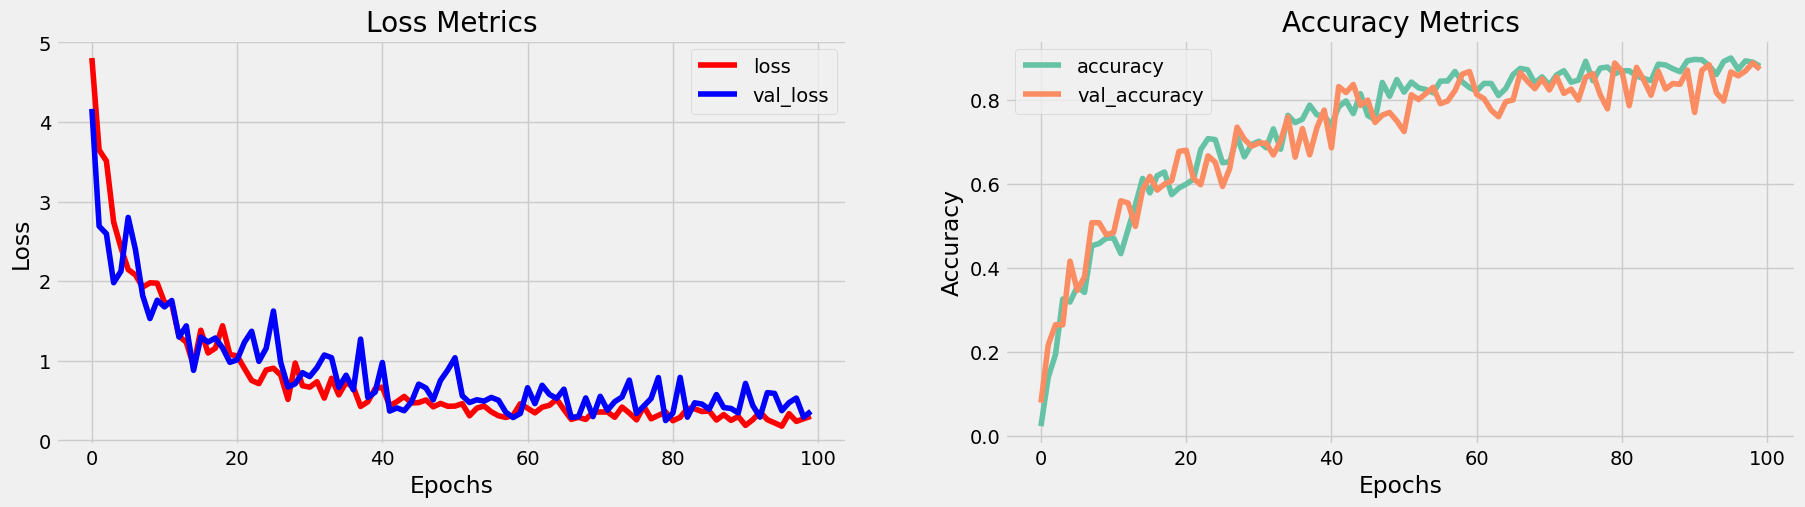

In [24]:
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(20,5))
ax[0].plot(history.history['loss'],label='loss',c='red')
ax[0].plot(history.history['val_loss'],label='val_loss',c = 'blue')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[1].set_ylabel('Accuracy')
ax[0].set_title('Loss Metrics')
ax[1].set_title('Accuracy Metrics')
ax[1].plot(history.history['accuracy'],label='accuracy')
ax[1].plot(history.history['val_accuracy'],label='val_accuracy')
ax[0].legend()
ax[1].legend()
plt.show()

In [25]:
model.load_weights('ckpt')
model.save('models',save_format='tf')

INFO:tensorflow:Assets written to: models\assets


INFO:tensorflow:Assets written to: models\assets


In [26]:
for idx,i in enumerate(model.layers):
    print('Encoder layers:' if idx==0 else 'Decoder layers: ')
    for j in i.layers:
        print(j)
    print('---------------------')

Encoder layers:
---------------------
Decoder layers: 
---------------------


In [27]:
class ChatBot(tf.keras.models.Model):
    def __init__(self,base_encoder,base_decoder,*args,**kwargs):
        super().__init__(*args,**kwargs)
        self.encoder,self.decoder=self.build_inference_model(base_encoder,base_decoder)

    def build_inference_model(self,base_encoder,base_decoder):
        encoder_inputs=tf.keras.Input(shape=(None,))
        x=base_encoder.layers[0](encoder_inputs)
        x=base_encoder.layers[1](x)
        x,encoder_state_h,encoder_state_c=base_encoder.layers[2](x)
        encoder=tf.keras.models.Model(inputs=encoder_inputs,outputs=[encoder_state_h,encoder_state_c],name='chatbot_encoder')

        decoder_input_state_h=tf.keras.Input(shape=(lstm_cells,))
        decoder_input_state_c=tf.keras.Input(shape=(lstm_cells,))
        decoder_inputs=tf.keras.Input(shape=(None,))
        x=base_decoder.layers[0](decoder_inputs)
        x=base_encoder.layers[1](x)
        x,decoder_state_h,decoder_state_c=base_decoder.layers[2](x,initial_state=[decoder_input_state_h,decoder_input_state_c])
        decoder_outputs=base_decoder.layers[-1](x)
        decoder=tf.keras.models.Model(
            inputs=[decoder_inputs,[decoder_input_state_h,decoder_input_state_c]],
            outputs=[decoder_outputs,[decoder_state_h,decoder_state_c]],name='chatbot_decoder'
        )
        return encoder,decoder

    def summary(self):
        self.encoder.summary()
        self.decoder.summary()

    def softmax(self,z):
        return np.exp(z)/sum(np.exp(z))

    def sample(self,conditional_probability,temperature=0.5):
        conditional_probability = np.asarray(conditional_probability).astype("float64")
        conditional_probability = np.log(conditional_probability) / temperature
        reweighted_conditional_probability = self.softmax(conditional_probability)
        probas = np.random.multinomial(1, reweighted_conditional_probability, 1)
        return np.argmax(probas)

    def preprocess(self,text):
        text=clean_text(text)
        seq=np.zeros((1,max_sequence_length),dtype=np.int32)
        for i,word in enumerate(text.split()):
            seq[:,i]=sequences2ids(word).numpy()[0]
        return seq
    
    def postprocess(self,text):
        text=re.sub(' - ','-',text.lower())
        text=re.sub(' [.] ','. ',text)
        text=re.sub(' [1] ','1',text)
        text=re.sub(' [2] ','2',text)
        text=re.sub(' [3] ','3',text)
        text=re.sub(' [4] ','4',text)
        text=re.sub(' [5] ','5',text)
        text=re.sub(' [6] ','6',text)
        text=re.sub(' [7] ','7',text)
        text=re.sub(' [8] ','8',text)
        text=re.sub(' [9] ','9',text)
        text=re.sub(' [0] ','0',text)
        text=re.sub(' [,] ',', ',text)
        text=re.sub(' [?] ','? ',text)
        text=re.sub(' [!] ','! ',text)
        text=re.sub(' [$] ','$ ',text)
        text=re.sub(' [&] ','& ',text)
        text=re.sub(' [/] ','/ ',text)
        text=re.sub(' [:] ',': ',text)
        text=re.sub(' [;] ','; ',text)
        text=re.sub(' [*] ','* ',text)
        text=re.sub(' [\'] ','\'',text)
        text=re.sub(' [\"] ','\"',text)
        return text

    def call(self,text,config=None):
        input_seq=self.preprocess(text)
        states=self.encoder(input_seq,training=False)
        target_seq=np.zeros((1,1))
        target_seq[:,:]=sequences2ids(['<start>']).numpy()[0][0]
        stop_condition=False
        decoded=[]
        while not stop_condition:
            decoder_outputs,new_states=self.decoder([target_seq,states],training=False)
#             index=tf.argmax(decoder_outputs[:,-1,:],axis=-1).numpy().item()
            index=self.sample(decoder_outputs[0,0,:]).item()
            word=ids2sequences([index])
            if word=='<end> ' or len(decoded)>=max_sequence_length:
                stop_condition=True
            else:
                decoded.append(index)
                target_seq=np.zeros((1,1))
                target_seq[:,:]=index
                states=new_states
        return self.postprocess(ids2sequences(decoded))

chatbot=ChatBot(model.encoder,model.decoder,name='chatbot')
chatbot.summary()

Model: "chatbot_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 encoder_embedding (Embeddin  (None, None, 256)        227840    
 g)                                                              
                                                                 
 layer_normalization (LayerN  (None, None, 256)        512       
 ormalization)                                                   
                                                                 
 encoder_lstm (LSTM)         [(None, None, 256),       525312    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 753,664
Trainable params: 753,664
Non

In [28]:
pip install pydot

You should consider upgrading via the 'c:\Users\Nuwanga Wijamuni\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [29]:
tf.keras.utils.plot_model(chatbot.encoder,to_file='encoder.png',show_shapes=True,show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [30]:
tf.keras.utils.plot_model(chatbot.decoder,to_file='decoder.png',show_shapes=True,show_layer_activations=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [31]:
def print_conversation(texts):
    for text in texts:
        print(f'Patient: {text}')
        print(f'DocBot: {chatbot(text)}')
        print('========================')

In [34]:
print_conversation([
    'Hellow Doctor',
    '''I haven't noticed any significant swelling''',
    ''' I'm just a bit concerned about the severity of the reaction'''

])

Patient: Hellow Doctor
DocBot: how can i assist you today? 
Patient: I haven't noticed any significant swelling
DocBot: i understand your concern. allergies can be quite serious. can you please describe the symptoms you're experiencing after having the mushroom salad? 
Patient:  I'm just a bit concerned about the severity of the reaction
DocBot: it's important to take these symptoms seriously and seek further evaluation. if you have been prescribed an epinephrine auto injector (epipen), make sure to carry it with you at all times and know. 
